# FACEBOOK DATA FROM YAHOO FINANCE

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("packtpub-src/csv/FB2012-2019.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-29,31.480000,31.690001,28.650000,28.840000,28.840000,78063400
1,2012-05-30,28.700001,29.549999,27.860001,28.190001,28.190001,57267900
2,2012-05-31,28.549999,29.670000,26.830000,29.600000,29.600000,111639200
3,2012-06-01,28.889999,29.150000,27.389999,27.719999,27.719999,41855500
4,2012-06-04,27.200001,27.650000,26.440001,26.900000,26.900000,35230300


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1755,2019-05-21,184.570007,185.699997,183.889999,184.820007,184.820007,7502800
1756,2019-05-22,184.729996,186.740005,183.610001,185.320007,185.320007,9213800
1757,2019-05-23,182.419998,183.899994,179.669998,180.869995,180.869995,12768800
1758,2019-05-24,182.330002,183.630005,180.830002,181.059998,181.059998,8807700
1759,2019-05-28,181.539993,184.710007,181.449997,184.309998,184.309998,14843300


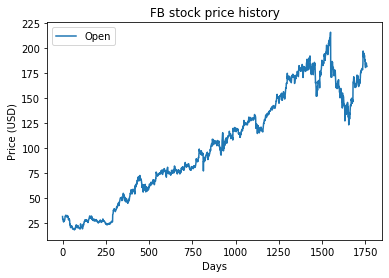

In [5]:
plt.figure()
plt.title("FB stock price history")
plt.plot(df['Open'])
#plt.plot(df["Close"])
#plt.plot(df["High"])
#plt.plot(df["Low"])
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'Close', 'High', 'Low'], loc='upper left')
plt.show()

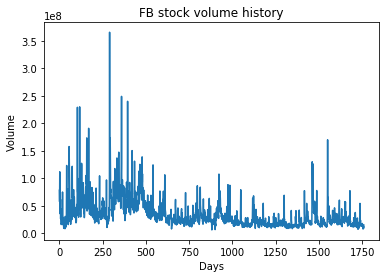

In [6]:
plt.figure()
plt.plot(df['Volume'])
plt.title('FB stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [7]:
print('Checking if any null values are present\n', df.isna().sum())

Checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### Normalizing the data
* Split the data into train, test
* Normalize
* Covert the DataFrame to ndarray

In [8]:
#! pip install keras

In [9]:
#! pip install np_utils

In [10]:
#! pip install tensorflow

In [11]:
#! pip install numpy --upgrade --user

In [12]:
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping

print('Checking GPU available', K.tensorflow_backend._get_available_gpus())


Using TensorFlow backend.


Checking GPU available []


In [13]:
from keras import losses

In [14]:
TIME_STEPS = 60
BATCH_SIZE = 20

In [15]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 10,
    "lr": 0.00010000,
    "time_steps": 60
}

In [16]:

train_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=True)
print('Train and test set', len(df_train), len(df_test))

#scale the feature MinMax, build array
x = df_train.loc[:, train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:, train_cols])

Train and test set 1408 352


In [17]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total nb of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    
    print('length of time-series i/o', x.shape, y.shape)
    return x, y

In [18]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that is divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0] % batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [19]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE), 2)

# x_t : train data
# x_val: validation data
# x_test_t: test data


length of time-series i/o (1348, 60, 5) (1348,)



length of time-series i/o (292, 60, 5) (292,)


In [20]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, time_steps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                       dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                       kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20, activation='relu'))
    lstm_model.add(Dense(1, activation='linear'))
    optimizer = optimizers.RMSprop(lr=params['lr'])
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    # lstm_model.compile(loss=losses.mean_squarred_error, optimizer=optimizer)
    return lstm_model

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=40, min_delta=0.0001)

In [25]:
model = create_model()

#csv_logger = CSVLogger()

history = model.fit(x_t, y_t, epochs=3, verbose=2, batch_size=BATCH_SIZE,
                   shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE), 
                                                   trim_dataset(y_val, BATCH_SIZE)),callbacks=[es])

Train on 1340 samples, validate on 140 samples
Epoch 1/3
 - 9s - loss: 0.1281 - val_loss: 0.0759
Epoch 2/3
 - 7s - loss: 0.0816 - val_loss: 0.0755
Epoch 3/3
 - 5s - loss: 0.0816 - val_loss: 0.0754


In [26]:
print(history.history.keys())
print(history.history['val_loss'])

dict_keys(['val_loss', 'loss'])
[0.07586273763860975, 0.07551193716270584, 0.0753868328673499]


Text(0, 0.5, 'Model loss')

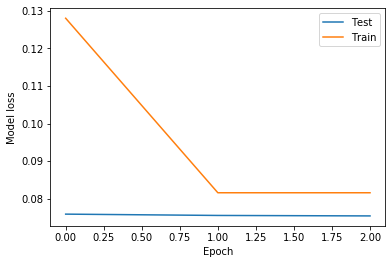

In [27]:
plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['Test', 'Train'])
plt.xlabel('Epoch')
plt.ylabel('Model loss')

In [43]:
# plot the predicted vs real price

In [28]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error", error, y_pred.shape, y_test_t.shape)

y_pred_orig = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_pred)
y_test_t_orig = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_test_t)

Error 0.07215081576388344 (140,) (140,)


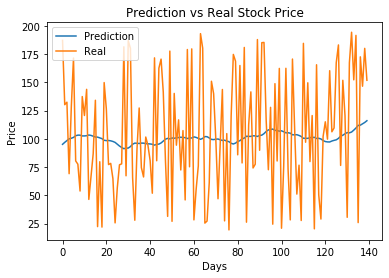

In [29]:
plt.figure()
plt.plot(y_pred_orig)
plt.plot(y_test_t_orig)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

In [30]:
# do gridsearch, put logging into
# what overfit would mean here?
# read lstm AK
# how to appreciate how good is the prediction?

# sentiment analysis for stock prediction ? X



In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
x_t.shape

(1340, 60, 5)

In [33]:
y_t

array([0.44546562, 0.07484514, 0.51863514, ..., 0.49192649, 0.2040723 ,
       0.23230426])

In [34]:
m = LinearRegression()

In [35]:
x_t[:,:,0].shape

(1340, 60)

In [36]:
rx_t = x_t[:,:,0]

In [37]:
rx_t[0:2].shape

(2, 60)

In [38]:
rx_t[0:2]

array([[0.67710503, 0.50626809, 0.21260722, 0.25082475, 0.2366137 ,
        0.38227682, 0.22915292, 0.03933411, 0.78668224, 0.34776429,
        0.31046033, 0.31604323, 0.9042278 , 0.74694209, 0.61919505,
        0.31594174, 0.57057301, 0.04222707, 0.52433639, 0.33157389,
        0.05598133, 0.83956757, 0.14302389, 0.247272  , 0.01730701,
        0.89691926, 0.76516264, 0.55981325, 0.88813889, 0.21321626,
        0.17814546, 0.05486474, 0.28934678, 0.58838753, 0.01390651,
        0.77810485, 0.88544888, 0.81845402, 0.69694967, 0.20651677,
        0.48576359, 0.67954119, 0.53555295, 0.02481855, 0.50418717,
        0.45673247, 0.31264274, 0.51474395, 0.03349744, 0.04841903,
        0.04207482, 0.76013808, 0.74572397, 0.21671826, 0.82083945,
        0.44866265, 0.76064557, 0.23554787, 0.29234127, 0.7773943 ],
       [0.50626809, 0.21260722, 0.25082475, 0.2366137 , 0.38227682,
        0.22915292, 0.03933411, 0.78668224, 0.34776429, 0.31046033,
        0.31604323, 0.9042278 , 0.74694209, 0.6

In [39]:
m.fit(rx_t, y_t)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
rx_test = x_test

In [41]:
rx_test = rx_test[-60:,0].reshape(-1, 1)

In [42]:
x_temp[:,:,0].shape

(292, 60)

In [43]:
y_pred=m.predict(x_temp[:,:,0])

In [44]:
from sklearn.metrics import mean_squared_error

In [45]:
mean_squared_error(y_temp,y_pred)

0.08251396510638316

In [46]:
y_temp

array([0.43998171, 0.42794761, 0.28724486, 0.03132934, 0.4288616 ,
       0.52904437, 0.71681728, 0.01518228, 0.78343661, 0.44785214,
       0.04905047, 0.04458211, 0.23590943, 0.05448359, 0.38199451,
       0.32705392, 0.65974411, 0.38788465, 0.48014625, 0.04041841,
       0.52675943, 0.01746725, 0.83807251, 0.2135168 , 0.44541484,
       0.03264954, 0.05133543, 0.52371283, 0.04727329, 0.75916526,
       0.29074844, 0.60927187, 0.58652385, 0.04062151, 0.30562607,
       0.15938864, 0.40250838, 0.81776176, 0.04138316, 0.21696963,
       0.02467757, 0.50847976, 0.54600387, 0.79029144, 0.58672692,
       0.1579669 , 0.02660708, 0.16512644, 0.77825735, 0.22844522,
       0.79846653, 0.38763075, 0.26591855, 0.28424901, 0.22864831,
       0.26353203, 0.86391793, 0.44932468, 0.29541995, 0.79613083,
       0.64212452, 0.62003655, 0.3653397 , 0.29389663, 0.61328321,
       0.68888999, 0.3037981 , 0.4795877 , 0.77566775, 0.78318271,
       0.54143395, 0.02726719, 0.03518838, 0.04580075, 0.03341

# STRATEGY

http://cs229.stanford.edu/proj2017/final-reports/5241098.pdf

We consider a simple algorithmic trading strategy based
on the prediction by the model. At day t, an investor buys
one share of INTC stock if the predicted price is higher
than the current actual adjusted closing price. Otherwise,
he or she sells one share of INTC stock. The strategy st
can be described as:
st =
(
+1 if yˆt+1 > yt
−1 if yˆt+1 ≤ yt

In [49]:
y_pred # prediction
pass

In [50]:
x_test_t # window
pass

In [51]:
# x_t : train data
# x_val: validation data
# x_test_t: test data

TODO
1. get data OK
2. write trading algorithm (function of the prediction) OK
3. compute returns

4. compute sharpe ratio of the strategy

In [57]:
y_pred_orig # predicted data
pass

In [58]:
y_test_t_orig # real data
pass

In [145]:
len(predicted_data) == len(real_data)

True

In [146]:
assert len(predicted_data) == len(real_data)
type(predicted_data), type(predicted_data[0])

(numpy.ndarray, numpy.float32)

In [105]:
class strategy():
    def __init__(self):
        self.stocks = 0
    
    def take_action(self, today_real_price, tomorrow_forcasted_price):
        """
         At day t, an investor buys one share of INTC stock if the predicted price 
         is higher than the current actual adjusted closing price.
         Otherwise, he or she sells one share of INTC stock"""
        if tomorrow_forcasted_price > today_real_price:
            self.stocks += 1
        else:
            self.stocks -= 1
    
    def compute_daily_return(self, today_real_price, tomorrow_real_price):
        """
         Using the
indicator variable st
, we can calculate a daily return of
the strategy at day t + 1:
rt+1 = st × log 
yt+1
yt

−
        """
        import math
        daily_return = self.stocks * math.log(tomorrow_real_price, today_real_price)
        return daily_return
            

In [147]:
def execute_strategy(strategy, predicted_data, verbose=True):
    """
    args: strategy to execute
    """
    cumulative_return = 0
    for day, today_real_price in enumerate(real_data[:-1]):
        # day by day and execute my strategy
        today_predicted_price = predicted_data[day]
        if verbose: print(day, today_real_price, today_predicted_price)
        
        strategy.take_action(today_real_price, predicted_data[day + 1])
        today_return = strategy.compute_daily_return(today_real_price, real_data[day + 1])
        # metric: cumulative return
        # sum of all the returns
        cumulative_return += today_return
    return cumulative_return

In [149]:
lstm_strategy = strategy() # you need initialize this every time
lstm_predicted_data = y_pred_orig # find prediction data

real_data = y_test_t_orig

lstm_strategy_return = execute_strategy(lstm_strategy, lstm_predicted_data, verbose=False)
lstm_strategy.stocks # how is my stock balance at the end of the execution:?
print(lstm_strategy_return)

992.6346143371755


In [150]:
regressor_strategy = strategy()
regression_predicted_data = y_pred_orig # TODO: find this
real_data = y_test_t_orig
regression_strategy_return = execute_strategy(regressor_strategy, regression_predicted_data, verbose=False)
regressor_strategy.stocks
print(regression_strategy_return)

992.6346143371755
